In [1387]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../include/")
import hhtools

import imp
imp.reload(hhtools)

<module 'hhtools' from '/home/jungyoung/Project/hh_neuralnet/three_pop_mpi/../include/hhtools.py'>

In [1027]:
def draw_cross_correlogram(vlfp, tlag_max):
    fig, axs = plt.subplots(2, 2, dpi=120, figsize=(6,6))
    for i in range(2):
        for j in range(2):
            c, tlags = cross_correlation(vlfp[i], vlfp[j], tlag_max=0.1)
            axs[i][j].plot(tlags, c, 'k')
            axs[i][j].grid(True)
            axs[i][j].set_ylim([-1, 1.1])
            axs[i][j].set_yticks(np.arange(-1, 1.1, 0.5))
    plt.tight_layout()
    plt.show()
    

def find_peaks(c, tlags):
    nid = np.argmax(c)
    return c[nid], tlags[nid]

In [1146]:
def cross_correlation(x, y, trange=None, dt=0.0005, tlag_max=None):
    """
    Cross-correlation between x and y
    - y will be moved to x
    - x and y must have same length
    
    Let t_peak is the peak time, 
    if t_peak < 0: y leads x
    if t_peak > 0: x leads y
    """
    if trange is not None:
        if trange[0] is None:
            trange[0] = 0
        if trange[1] is None:
            trange[1] = len(x)*dt
        n0 = int(trange[0]/dt)
        n1 = int(trange[1]/dt)
    
    x = x[n0:n1]
    y = y[n0:n1]
    
    xs = np.array(x) - np.average(x)
    ys = np.array(y) - np.average(y)
    
    if tlag_max is None:
        c = np.correlate(xs, ys, mode="full")
        num = np.concatenate([np.arange(1, len(ys)), np.arange(len(ys), 0, -1)])
        c = c / num
        num_lag = len(ys)-1
        
    else:
        num_lag = int(tlag_max/dt)
        arr_app = np.zeros(num_lag)
        xs_tmp = np.concatenate((arr_app, xs, arr_app))
        
        c = np.correlate(xs_tmp, ys, mode="valid")
        n0 = len(ys) - num_lag
        num = np.concatenate((np.arange(n0, len(ys)), np.arange(len(ys), n0-1, -1)))
        c = c / num
    
    c /= np.std(xs) * np.std(ys)
    tlags = np.arange(-num_lag, num_lag+1) * dt
    
    return c, tlags


def find_corr_peaks(c, prominence=0.05):
    from scipy.signal import find_peaks
    
    ind_peaks, _ = find_peaks(c, prominence=prominence)
    n0 = len(c)//2
    
    # sort them with distance from zero-point
    dn = np.abs(ind_peaks - n0)
    ind = np.argsort(dn)
    return ind_peaks[ind[:3]]


def get_period(x, **kwargs):
    c_auto, tlags  = cross_correlation(x, x, **kwargs)
    nid_peak_a = find_corr_peaks(c_auto)
    return np.abs(tlags[nid_peak_a[0]] - tlags[nid_peak_a[1]])


def calculate_dphs(x, y, trange=None, dt=0.0005, tlag_max=0.1):
    # calculate the phase difference compared to x
    c_auto, _  = cross_correlation(x, x, trange=trange, dt=dt, tlag_max=tlag_max)
    c_cross, _ = cross_correlation(x, y, trange=trange, dt=dt, tlag_max=tlag_max)
    
    # calculate the phase difference
    T = get_period(x, trange=trange, dt=dt, tlag_max=tlag_max)
    nid_peak_c = find_corr_peaks(c_cross)
    dn = nid_peak_c[1] - len(c_cross)//2
    
    dphs = dn*dt / T
    dphs -= dphs//1
    if dphs > 0.5:
        dphs = dphs - 1
    
    return dphs
    

# Symmectric case

In [1388]:
obj = hhtools.SummaryLoader("./symmetric_case2/", num_overlap=18)
print(obj.summary["chi"].shape)
print(obj.controls.keys())

(15, 15, 3, 2, 18, 3)
dict_keys(['alpha_set', 'beta_set', 'id_rank'])


In [1389]:
obj.summary["chi"].shape

(15, 15, 3, 2, 18, 3)

In [1390]:
nid_rank = 2

chis_avg = np.zeros([15, 15, 3])
chis_std = np.zeros([15, 15, 3])

frs_avg = np.zeros([15, 15, 3])

for n in range(3):
    im = obj.summary["chi"][:,:,nid_rank,:,:,n]
    im = np.reshape(im, [15, 15, 2*18])
    chis_avg[:,:,n] = np.average(im, axis=2)
    chis_std[:,:,n] = np.std(im, axis=2)
    
    im = obj.summary["frs_m"][:,:,nid_rank,:,:,n]
    im = np.reshape(im, [15, 15, 2*18])
    frs_avg[:,:,n] = np.average(im, axis=2)

Global synchrony / pop1 synchrony / pop2 synchrony


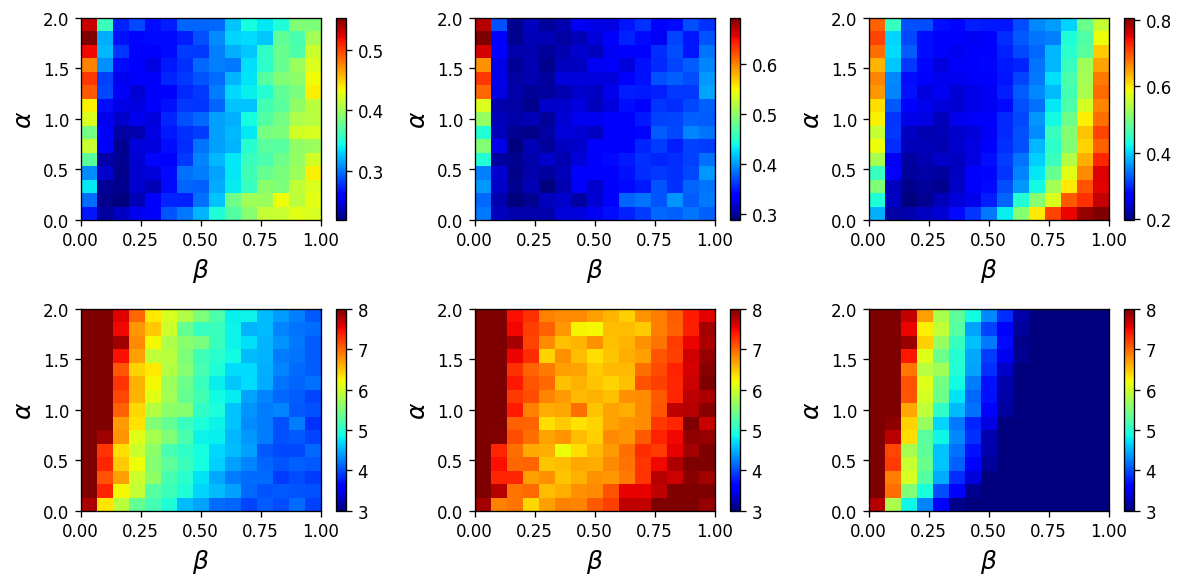

In [1391]:
x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]

print("Global synchrony / pop1 synchrony / pop2 synchrony")

fig, axs = plt.subplots(2, 3, dpi=120, figsize=(10, 5))
for n in range(3):
    plt.axes(axs[0][n])
    hhtools.imshow_xy(chis_avg[:,:,n], x=x, y=y, cmap="jet")
    plt.colorbar()
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)

for n in range(3):
    plt.axes(axs[1][n])
    # hhtools.imshow_xy(chis_std[:,:,n], x=x, y=y, cmap="jet")
    hhtools.imshow_xy(frs_avg[:,:,n], x=x, y=y, cmap="jet", vmax=8, vmin=3)
    plt.colorbar()
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)
    
plt.tight_layout()
plt.show()

## Sample figure

### Raster

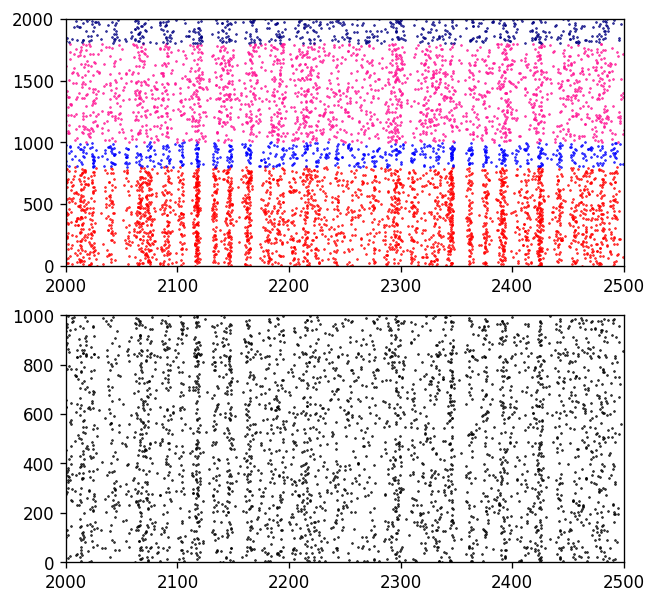

In [1437]:
# data = obj.load_detail(0, 0, 2, 0)
data = obj.load_detail(5, 3, 2, 0)

plt.figure(dpi=120, figsize=(6, 6))
plt.subplot(211)
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2000, 2500))

plt.subplot(212)
# nid = np.random.permutation(np.arange(500))

nid = np.random.choice(np.arange(2000), size=1000, replace=False)
step_tmp = []
for n in nid:
    step_tmp.append(data["step_spk"][n])
hhtools.draw_spk(step_tmp, color_ranges=None, xl=(2000, 2500))

plt.show()

### spectrogram

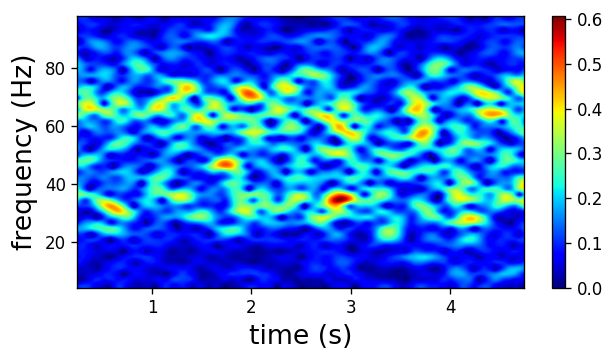

In [1406]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

## Phase relation

In [1414]:
nid_rank = 2

tw = 1
tm = 0.1
tmax = 2.5

sz = np.shape(obj.summary["chi"]) # alpha, beta, id_rank, iteration
tbins = np.arange(1, tmax-tw+tm/2, tm)
sz_t = len(tbins)

c_auto1 = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan # second peak of autocorrelation
c_auto2 = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan # second peak of autocorrelation
c_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan # first peak of cross correlation
tlag_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
dphs = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
freqs = np.zeros([sz[0], sz[1], sz[3]*sz_t, 2]) * np.nan

for n1 in range(sz[0]): # y
    for n2 in range(sz[1]): # x
        for n3 in range(sz[3]): # iteration
            data = obj.load_detail(n1, n2, nid_rank, n3)
            for i, t0 in enumerate(tbins):
                c1, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][1], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c1, tlags)
                c_auto1[n1, n2, n3*sz_t+i] = c1[ind_peaks[1]]
                # frequency change
                del_t = (abs(tlags[ind_peaks[0]] - tlags[ind_peaks[1]]) + abs(tlags[ind_peaks[0]] - tlags[ind_peaks[2]]))/2
                freqs[n1, n2, n3*sz_t+i, 0] = 1/del_t
                
                c2, tlags = cross_correlation(data['vlfp'][2], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c2, tlags)
                c_auto2[n1, n2, n3*sz_t+i] = c2[ind_peaks[1]]
                # frequency change
                del_t = (abs(tlags[ind_peaks[0]] - tlags[ind_peaks[1]]) + abs(tlags[ind_peaks[0]] - tlags[ind_peaks[2]]))/2
                freqs[n1, n2, n3*sz_t+i, 1] = 1/del_t
                
                c, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c, tlags)
                c_peaks[n1, n2, n3*sz_t+i] = c[ind_peaks[0]]
                
                dphs[n1, n2, n3*sz_t+i] = calculate_dphs(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                tlag_peaks[n1, n2, n3*sz_t+i] = tlags[nl]

### Second peak for autocorrelation

Second peak of autocorrelation for pop F (Upper) / Second peak of autocorrelation for pop L (Lower)


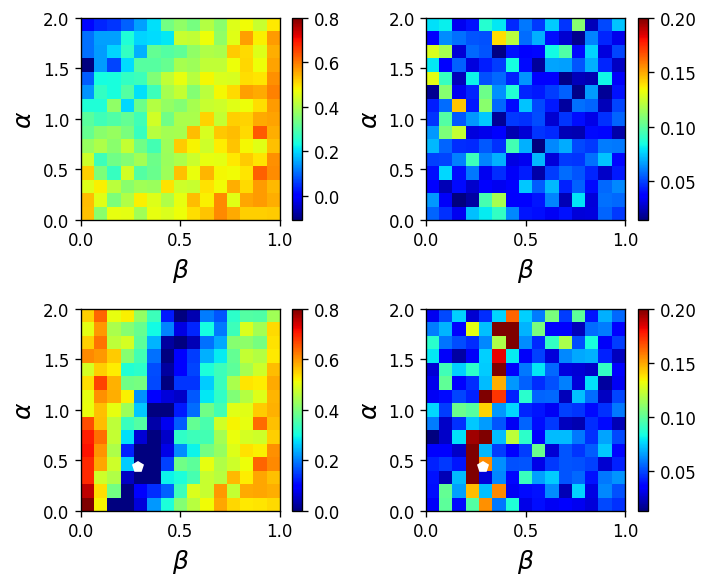

In [1430]:
print("Second peak of autocorrelation for pop F (Upper) / Second peak of autocorrelation for pop L (Lower)")

plt.figure(dpi=120, figsize=(6, 5))

plt.subplot(221)
hhtools.imshow_xy(np.average(c_auto1, axis=2), x=x, y=y, cmap="jet", vmax=0.8)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(222)
hhtools.imshow_xy(np.std(c_auto1, axis=2), x=x, y=y, cmap="jet", vmax=0.2)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(223)
hhtools.imshow_xy(np.average(c_auto2, axis=2), x=x, y=y, cmap="jet", vmax=0.8, vmin=0)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)
plt.plot(x[4], y[3], 'wp')

plt.subplot(224)
hhtools.imshow_xy(np.std(c_auto2, axis=2), x=x, y=y, cmap="jet", vmax=0.2)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)
plt.plot(x[4], y[3], 'wp')

plt.tight_layout()

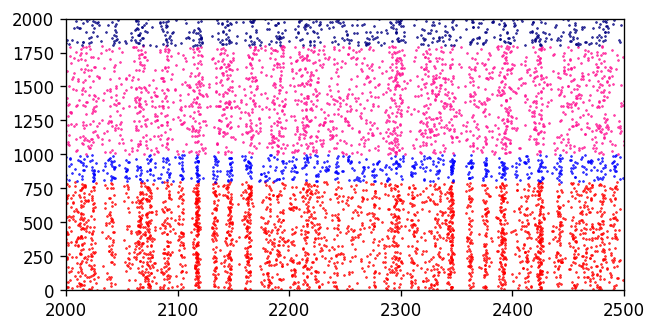

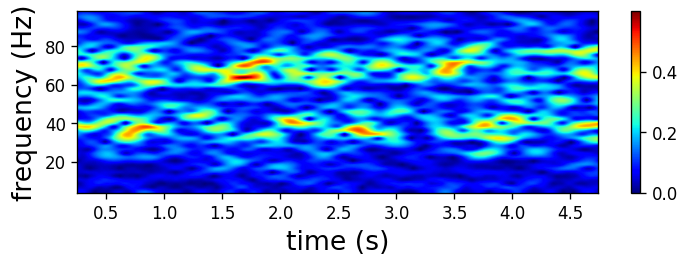

In [1431]:
# data = obj.load_detail(0, 0, 2, 0)
data = obj.load_detail(5, 3, 2, 0)

plt.figure(dpi=120, figsize=(6, 3))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2000, 2500))
plt.show()

yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(7, 2))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

### Frequency change

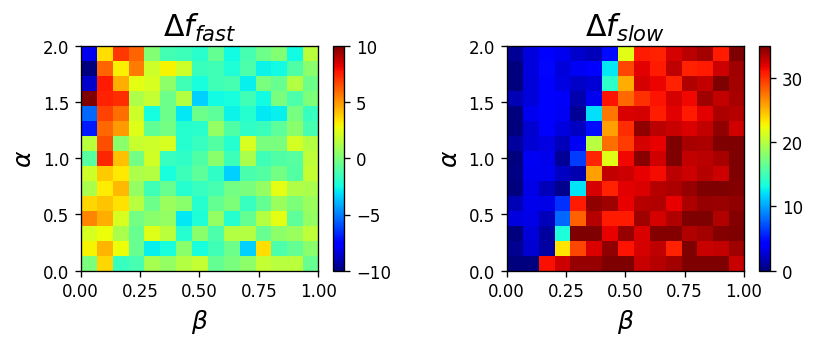

In [1418]:
plt.figure(dpi=120, figsize=(7,3.))
plt.subplot(121)
df1 = np.average(freqs[:,:,:,0], axis=2) - np.average(freqs[0,0,:,0])
hhtools.imshow_xy(df1, x=x, y=y, cmap="jet", vmin=-10, vmax=10)
plt.colorbar()
plt.title(r"$\Delta f_{fast} $", fontsize=18)
plt.xlabel(r"$\beta$", fontsize=15)
plt.ylabel(r"$\alpha$", fontsize=15)

plt.subplot(122)
df2 = np.average(freqs[:,:,:,1], axis=2) - np.average(freqs[0,0,:,1])
hhtools.imshow_xy(df2, x=x, y=y, cmap="jet", vmin=0, vmax=35)
plt.colorbar()
plt.title(r"$\Delta f_{slow} $", fontsize=18)
plt.xlabel(r"$\beta$", fontsize=15)
plt.ylabel(r"$\alpha$", fontsize=15)

plt.tight_layout()
plt.show()

### Cross correlation and phase relation

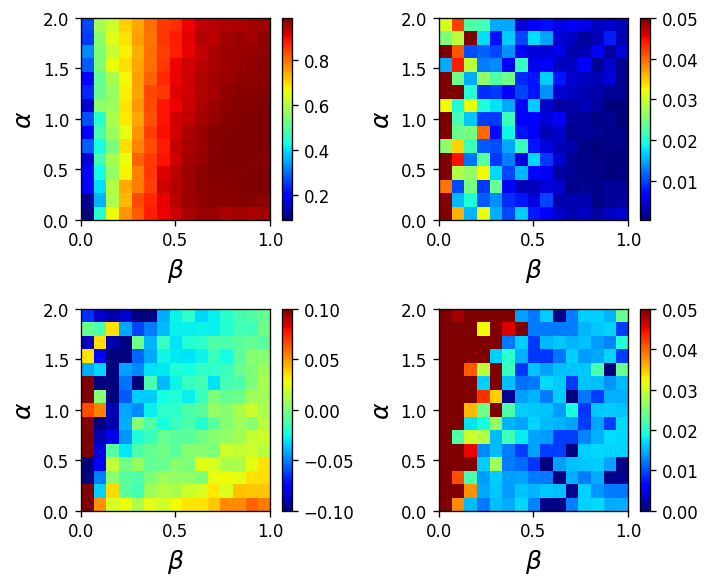

In [1420]:
plt.figure(dpi=120, figsize=(6, 5))

plt.subplot(221)
hhtools.imshow_xy(np.average(c_peaks, axis=2), x=x, y=y, cmap="jet",)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(222)
hhtools.imshow_xy(np.std(c_peaks, axis=2), x=x, y=y, cmap="jet", vmax=0.05)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(223)
hhtools.imshow_xy(average_angle(dphs, axis=2), x=x, y=y, cmap="jet", vmax=0.1, vmin=-0.1)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(224)
hhtools.imshow_xy(np.std(dphs, axis=2), x=x, y=y, cmap="jet", vmax=0.05)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.tight_layout()

# Symmetric case

In [1327]:
obj = hhtools.SummaryLoader("./symmetric_case/", num_overlap=13)
print(obj.summary["chi"].shape)
print(obj.controls.keys())

(15, 15, 5, 5, 13, 3)
dict_keys(['alpha_set', 'beta_set', 'id_rank'])


In [1328]:
nid_rank = 2

chis_avg = np.zeros([15, 15, 3])
chis_std = np.zeros([15, 15, 3])

frs_avg = np.zeros([15, 15, 3])

for n in range(3):
    im = obj.summary["chi"][:,:,nid_rank,:,:,n]
    im = np.reshape(im, [15, 15, 5*13])
    chis_avg[:,:,n] = np.average(im, axis=2)
    chis_std[:,:,n] = np.std(im, axis=2)
    
    im = obj.summary["frs_m"][:,:,nid_rank,:,:,n]
    im = np.reshape(im, [15, 15, 5*13])
    frs_avg[:,:,n] = np.average(im, axis=2)

Global synchrony / pop1 synchrony / pop2 synchrony


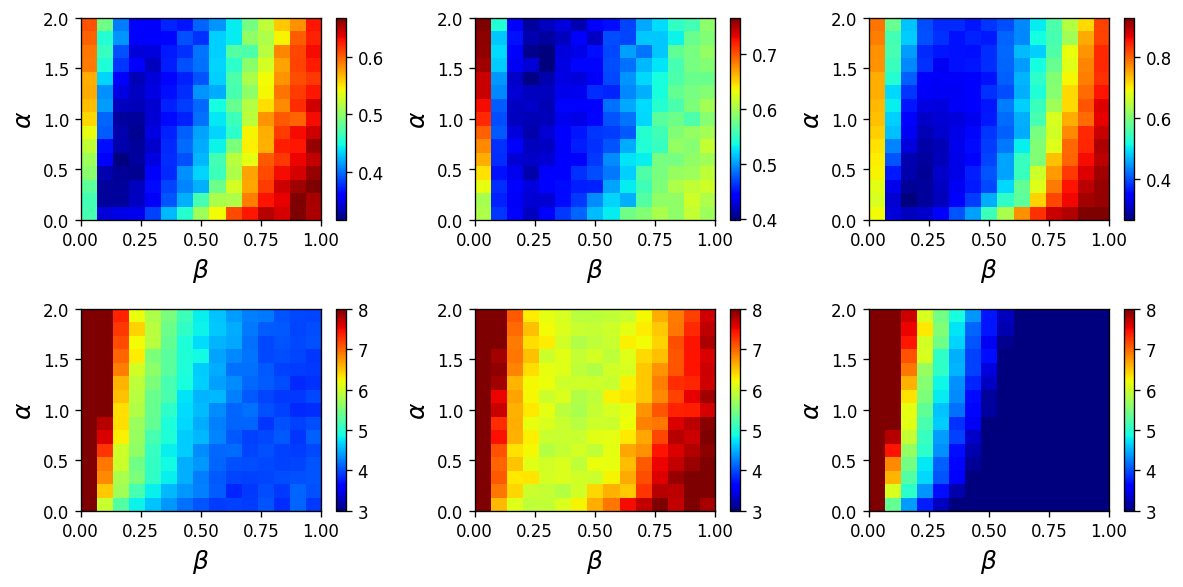

In [1329]:
x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]

print("Global synchrony / pop1 synchrony / pop2 synchrony")

fig, axs = plt.subplots(2, 3, dpi=120, figsize=(10, 5))
for n in range(3):
    plt.axes(axs[0][n])
    hhtools.imshow_xy(chis_avg[:,:,n], x=x, y=y, cmap="jet")
    plt.colorbar()
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)

for n in range(3):
    plt.axes(axs[1][n])
    # hhtools.imshow_xy(chis_std[:,:,n], x=x, y=y, cmap="jet")
    hhtools.imshow_xy(frs_avg[:,:,n], x=x, y=y, cmap="jet", vmax=8, vmin=3)
    plt.colorbar()
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)
    
plt.tight_layout()
plt.show()

In [ ]:
x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]

print("Global synchrony / pop1 synchrony / pop2 synchrony")

fig, axs = plt.subplots(2, 3, dpi=120, figsize=(10, 5))
for n in range(3):
    plt.axes(axs[0][n])
    hhtools.imshow_xy(chis_avg[:,:,n], x=x, y=y, cmap="jet")
    plt.colorbar()
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)

for n in range(3):
    plt.axes(axs[1][n])
    hhtools.imshow_xy(chis_std[:,:,n], x=x, y=y, cmap="jet")
    plt.colorbar()
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)
    
plt.tight_layout()
plt.show()

## Sample figure

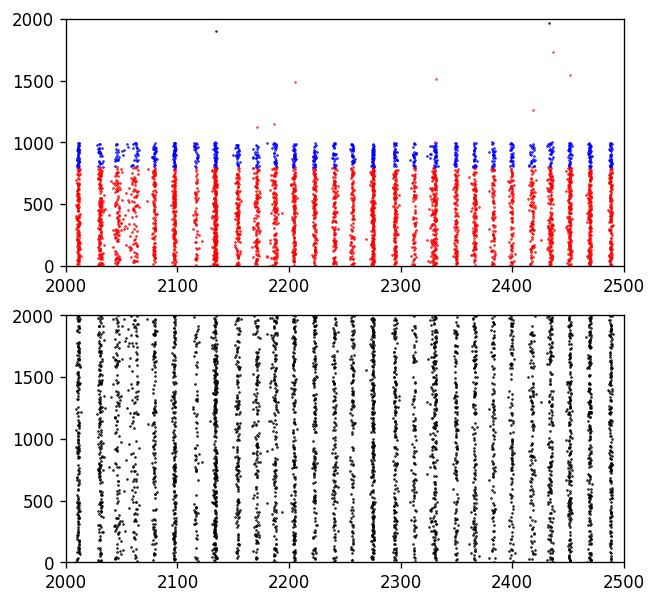

In [1272]:
# data = obj.load_detail(0, 0, 2, 0)
data = obj.load_detail(2, 13, 2, 0)

plt.figure(dpi=120, figsize=(6, 6))
plt.subplot(211)
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2000, 2500))

plt.subplot(212)
nid = np.random.permutation(np.arange(2000))
hhtools.draw_spk(data["step_spk"], color_ranges=None, xl=(2000, 2500), sequence=nid)

plt.show()

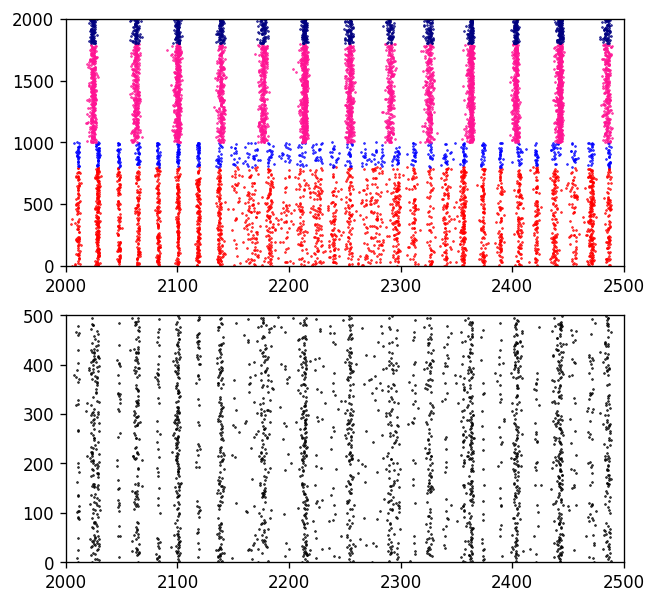

In [1310]:
# data = obj.load_detail(0, 0, 2, 0)
data = obj.load_detail(0, 0, 2, 0)

plt.figure(dpi=120, figsize=(6, 6))
plt.subplot(211)
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2000, 2500))

plt.subplot(212)
nid = np.random.permutation(np.arange(500))
hhtools.draw_spk(data["step_spk"][::4], color_ranges=None, xl=(2000, 2500), sequence=nid)

plt.show()

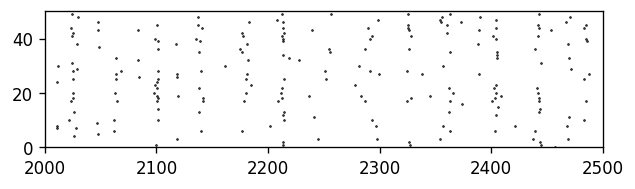

In [1315]:
plt.figure(dpi=120, figsize=(6, 1.5))
nid = np.random.permutation(np.arange(50))
hhtools.draw_spk(data["step_spk"][::40], color_ranges=None, xl=(2000, 2500), sequence=nid)

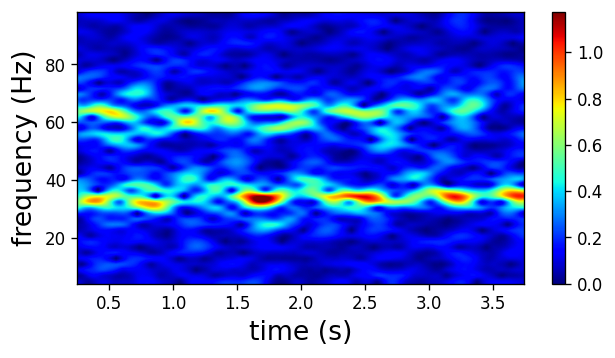

In [1270]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

In [1287]:
nid_rank = 2

tw = 1
tm = 0.1
tmax = 2.5

sz = np.shape(obj.summary["chi"]) # alpha, beta, id_rank, iteration
tbins = np.arange(1, tmax-tw+tm/2, tm)
sz_t = len(tbins)

# c_peaks1 = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
# c_peaks2 = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
c_auto1 = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
c_auto2 = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
c_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan

tlag_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
dphs = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan

for n1 in range(sz[0]): # y
    for n2 in range(sz[1]): # x
        for n3 in range(sz[3]): # iteration
            data = obj.load_detail(n1, n2, nid_rank, n3)
            for i, t0 in enumerate(tbins):
                c1, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][1], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c1, tlags)
                c_auto1[n1, n2, n3*sz_t+i] = c1[ind_peaks[1]]
                
                c2, tlags = cross_correlation(data['vlfp'][2], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c2, tlags)
                c_auto2[n1, n2, n3*sz_t+i] = c2[ind_peaks[1]]
                
                
                c, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c, tlags)
                c_peaks[n1, n2, n3*sz_t+i] = c[ind_peaks[0]]
                
                dphs[n1, n2, n3*sz_t+i] = calculate_dphs(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                tlag_peaks[n1, n2, n3*sz_t+i] = tlags[nl]

In [1282]:
def average_angle(im, axis=0):
    im_exp = np.average(np.exp(1j * im), axis=axis)
    return np.angle(im_exp)


def std_angle(im, axis=0):
    agl2 = average_angle(im**2)
    agl1 = average_angle(im)**2
    return agl2 - agl1

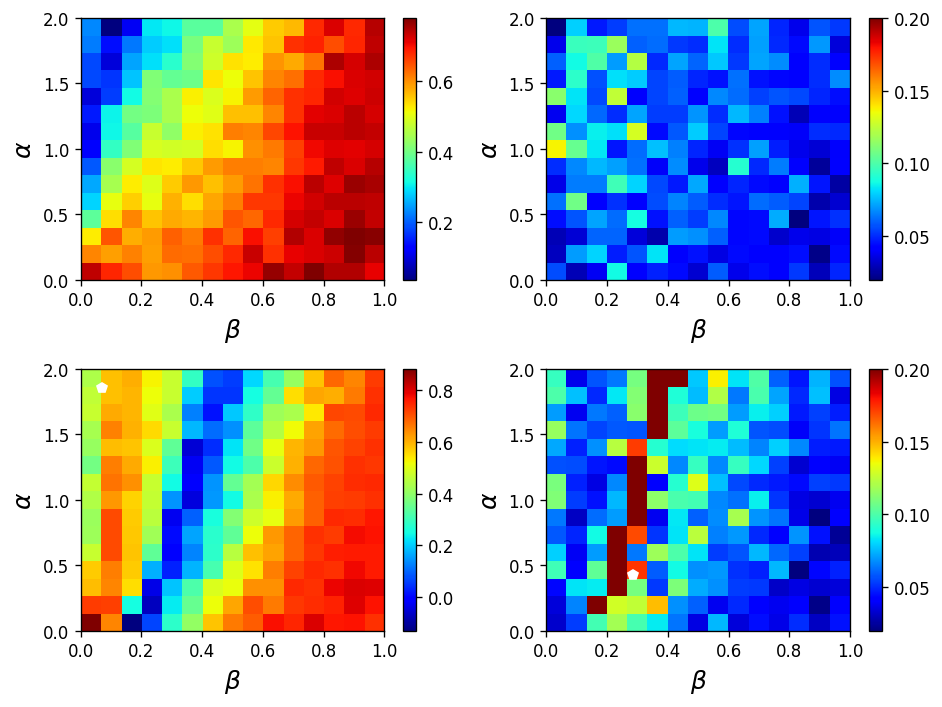

In [1305]:
plt.figure(dpi=120, figsize=(8, 6))

plt.subplot(221)
hhtools.imshow_xy(np.average(c_auto1, axis=2), x=x, y=y, cmap="jet",)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(222)
hhtools.imshow_xy(np.std(c_auto1, axis=2), x=x, y=y, cmap="jet", vmax=0.2)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(223)
hhtools.imshow_xy(np.average(c_auto2, axis=2), x=x, y=y, cmap="jet",)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)
plt.plot(x[1], y[13], 'wp')

plt.subplot(224)
hhtools.imshow_xy(np.std(c_auto2, axis=2), x=x, y=y, cmap="jet", vmax=0.2)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)
plt.plot(x[4], y[3], 'wp')

plt.tight_layout()

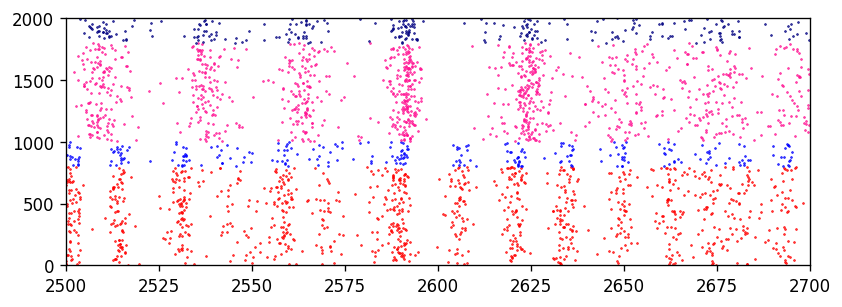

In [1346]:
# data = obj.load_detail(0, 0, 2, 0)
# data = obj.load_detail(3, 4, 2, 0)
data = obj.load_detail(13, 2, 2, 0)

plt.figure(dpi=120, figsize=(8, 6))
plt.subplot(211)
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2500, 2700))

# plt.subplot(212)
# nid = np.random.permutation(np.arange(2000))
# hhtools.draw_spk(data["step_spk"], color_ranges=None, xl=(2000, 2500), sequence=nid)

plt.show()

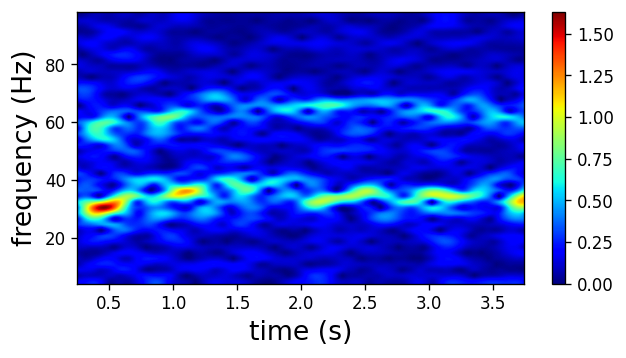

In [1347]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

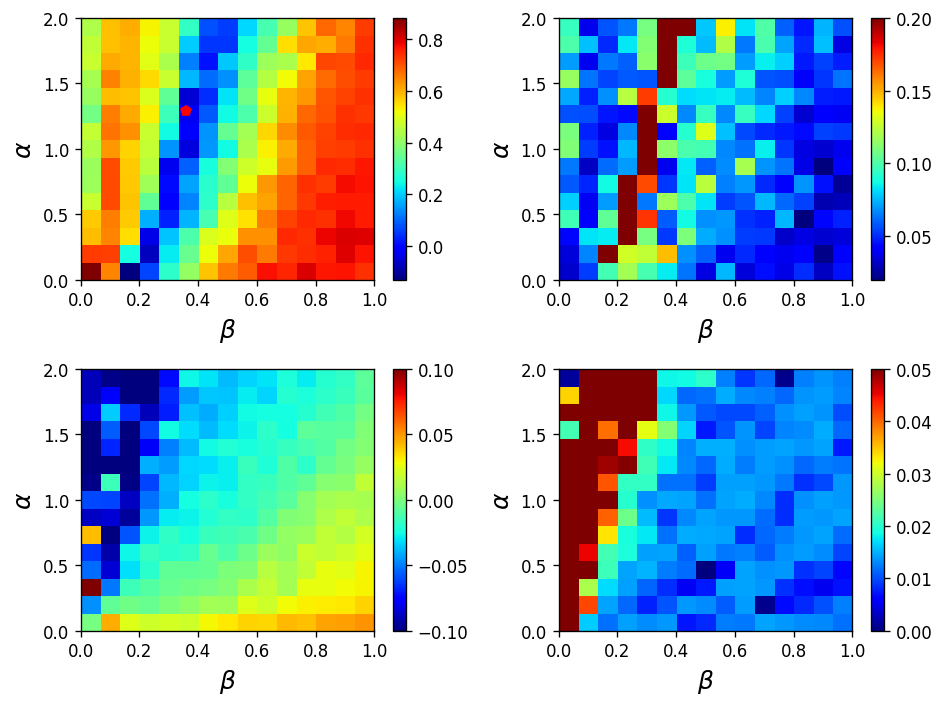

In [1355]:
# second peak of autocorrelation

plt.figure(dpi=120, figsize=(8, 6))

plt.subplot(221)
hhtools.imshow_xy(np.average(c_auto2, axis=2), x=x, y=y, cmap="jet",)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)
plt.plot(x[5], y[9], 'rp')

plt.subplot(222)
hhtools.imshow_xy(np.std(c_auto2, axis=2), x=x, y=y, cmap="jet", vmax=0.2)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(223)
hhtools.imshow_xy(average_angle(dphs, axis=2), x=x, y=y, cmap="jet", vmax=0.1, vmin=-0.1)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(224)
hhtools.imshow_xy(np.std(dphs, axis=2), x=x, y=y, cmap="jet", vmax=0.05)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.tight_layout()

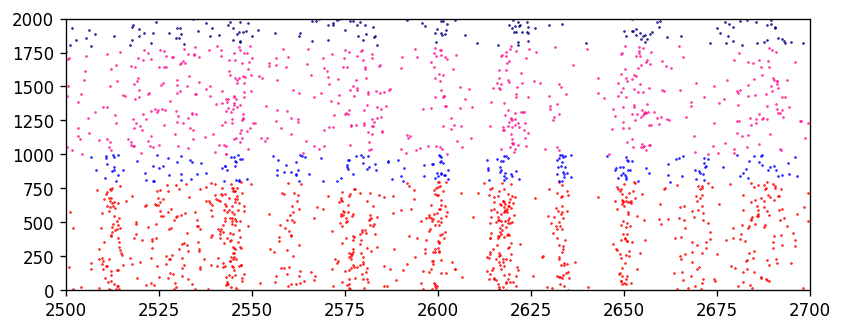

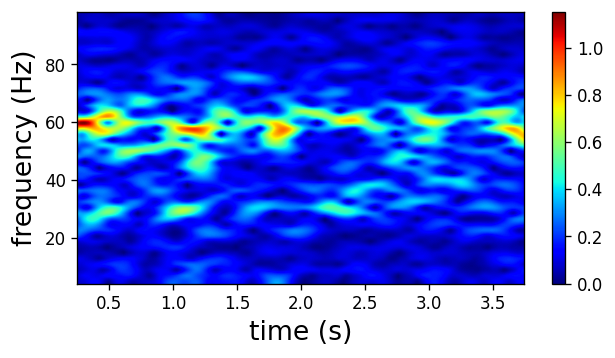

In [1373]:
data = obj.load_detail(9, 6, 2, 0)

plt.figure(dpi=120, figsize=(8, 3))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2500, 2700))

yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)
plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

In [1357]:
# frequency of auto correlation

nid_rank = 2

tw = 1
tm = 0.1
tmax = 2.5

sz = np.shape(obj.summary["chi"]) # alpha, beta, id_rank, iteration
tbins = np.arange(1, tmax-tw+tm/2, tm)
sz_t = len(tbins)

freqs = np.zeros([sz[0], sz[1], sz[3]*sz_t, 2]) * np.nan

for n1 in range(sz[0]): # y
    for n2 in range(sz[1]): # x
        for n3 in range(sz[3]): # iteration
            data = obj.load_detail(n1, n2, nid_rank, n3)
            for i, t0 in enumerate(tbins):
                c1, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][1], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c1, tlags)
                del_t = (abs(tlags[ind_peaks[0]] - tlags[ind_peaks[1]]) + abs(tlags[ind_peaks[0]] - tlags[ind_peaks[2]]))/2
                freqs[n1, n2, n3*sz_t+i, 0] = 1/del_t
                
                c2, tlags = cross_correlation(data['vlfp'][2], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c2, tlags)
                del_t = (abs(tlags[ind_peaks[0]] - tlags[ind_peaks[1]]) + abs(tlags[ind_peaks[0]] - tlags[ind_peaks[2]]))/2
                freqs[n1, n2, n3*sz_t+i, 1] = 1/del_t


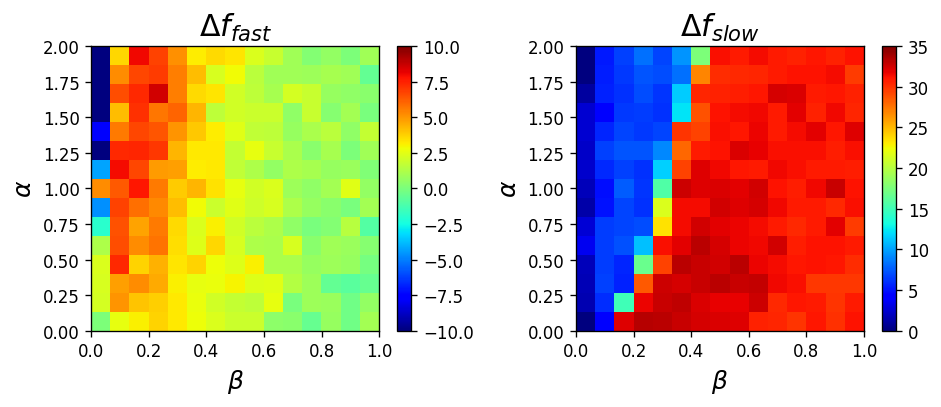

In [1370]:
plt.figure(dpi=120, figsize=(8,3.5))
plt.subplot(121)
df1 = np.average(freqs[:,:,:,0], axis=2) - np.average(freqs[0,0,:,0])
hhtools.imshow_xy(df1, x=x, y=y, cmap="jet", vmin=-10, vmax=10)
plt.colorbar()
plt.title(r"$\Delta f_{fast} $", fontsize=18)
plt.xlabel(r"$\beta$", fontsize=15)
plt.ylabel(r"$\alpha$", fontsize=15)

plt.subplot(122)
df2 = np.average(freqs[:,:,:,1], axis=2) - np.average(freqs[0,0,:,1])
hhtools.imshow_xy(df2, x=x, y=y, cmap="jet", vmin=0, vmax=35)
plt.colorbar()
plt.title(r"$\Delta f_{slow} $", fontsize=18)
plt.xlabel(r"$\beta$", fontsize=15)
plt.ylabel(r"$\alpha$", fontsize=15)

plt.tight_layout()
plt.show()

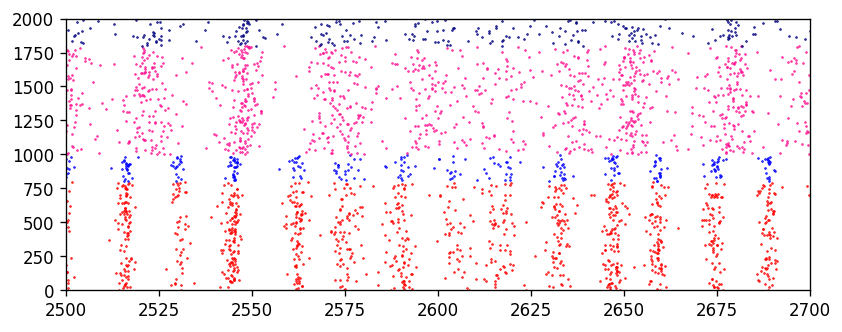

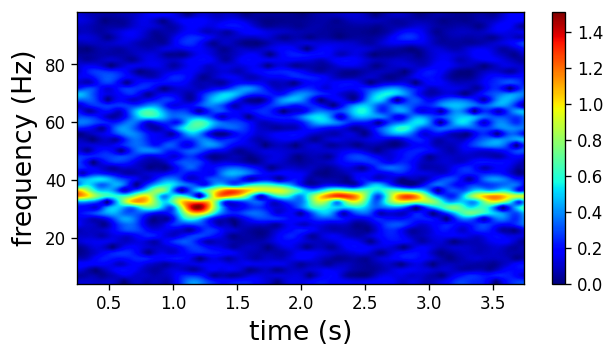

In [1375]:
data = obj.load_detail(12, 2, 2, 0)

plt.figure(dpi=120, figsize=(8, 3))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2500, 2700))

yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)
plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

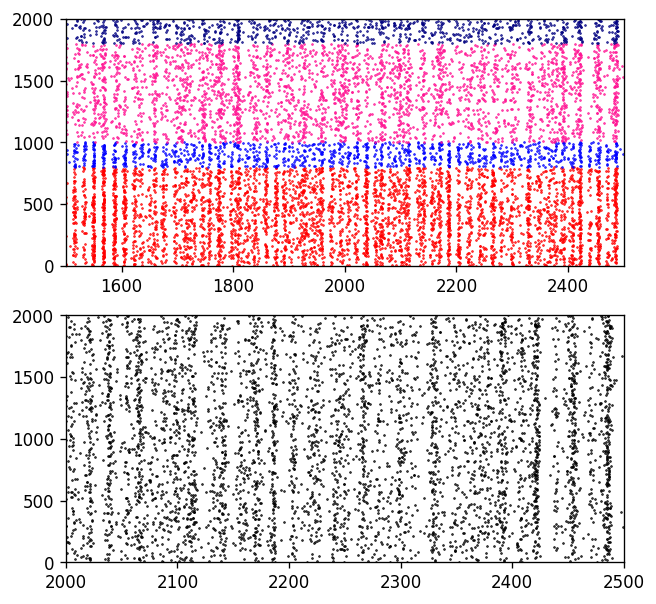

In [1294]:
# data = obj.load_detail(0, 0, 2, 0)
data = obj.load_detail(9, 5, 2, 0)

plt.figure(dpi=120, figsize=(6, 6))
plt.subplot(211)
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(1500, 2500))

# plt.subplot(212)
# nid = np.random.permutation(np.arange(2000))
# hhtools.draw_spk(data["step_spk"], color_ranges=None, xl=(2000, 2500), sequence=nid)

plt.show()

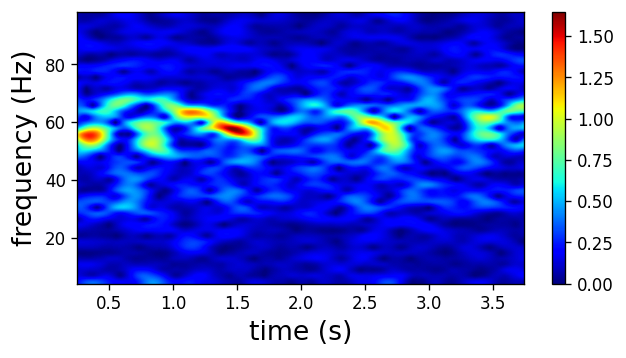

In [1297]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][1], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

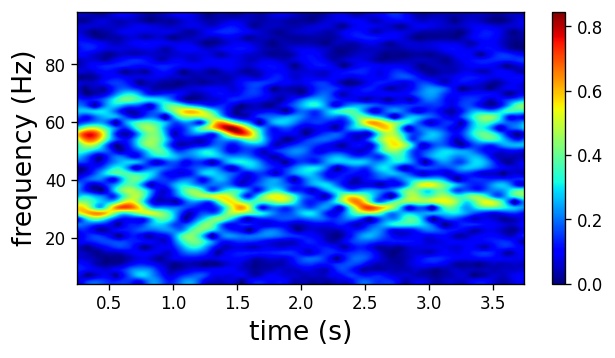

In [1296]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][2], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

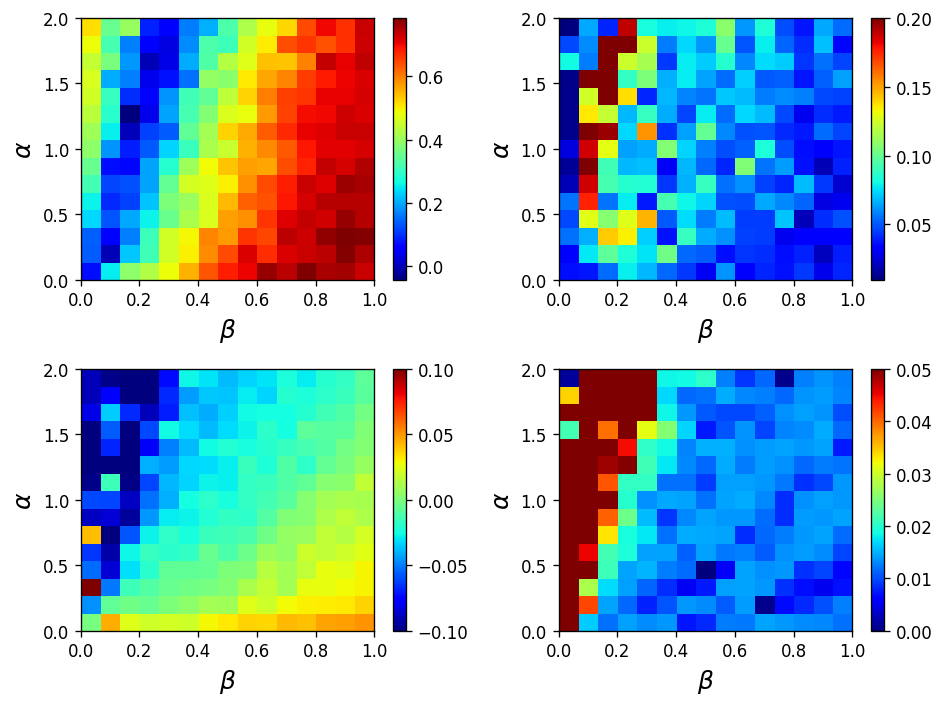

In [1284]:
plt.figure(dpi=120, figsize=(8, 6))

plt.subplot(221)
hhtools.imshow_xy(np.average(c_peaks, axis=2), x=x, y=y, cmap="jet",)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(222)
hhtools.imshow_xy(np.std(c_peaks, axis=2), x=x, y=y, cmap="jet", vmax=0.2)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(223)
hhtools.imshow_xy(average_angle(dphs, axis=2), x=x, y=y, cmap="jet", vmax=0.1, vmin=-0.1)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(224)
hhtools.imshow_xy(np.std(dphs, axis=2), x=x, y=y, cmap="jet", vmax=0.05)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.tight_layout()

In [ ]:
nid_rank = 2

tw = 1
tm = 0.1
tmax = 2.5

sz = np.shape(obj.summary["chi"]) # alpha, beta, id_rank, iteration
tbins = np.arange(1, tmax-tw+tm/2, tm)
sz_t = len(tbins)

c_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
tlag_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
dphs = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan

for n1 in range(sz[0]): # y
    for n2 in range(sz[1]): # x
        for n3 in range(sz[3]): # iteration
            data = obj.load_detail(n1, n2, nid_rank, n3)
            for i, t0 in enumerate(tbins):
                c, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                ind_peaks = find_corr_peaks(c, tlags)
                
                c_peaks[n1, n2, n3*sz_t+i] = c[ind_peaks[1]]
                
                dphs[n1, n2, n3*sz_t+i] = calculate_dphs(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                tlag_peaks[n1, n2, n3*sz_t+i] = tlags[nl]

In [ ]:
plt.figure(dpi=120, figsize=(8, 6))

plt.subplot(221)
hhtools.imshow_xy(np.average(c_peaks, axis=2), x=x, y=y, cmap="jet",)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(222)
hhtools.imshow_xy(np.std(c_peaks, axis=2), x=x, y=y, cmap="jet", vmax=0.05)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(223)
hhtools.imshow_xy(average_angle(dphs, axis=2), x=x, y=y, cmap="jet", vmax=0.1, vmin=-0.1)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.subplot(224)
hhtools.imshow_xy(np.std(dphs, axis=2), x=x, y=y, cmap="jet", vmax=0.05)
plt.colorbar()
plt.ylabel(r"$\alpha$", fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)

plt.tight_layout()

In [1256]:
a1 = np.random.randn(100) + (-np.pi)
nid = a1 < -np.pi
a1[nid] = -2*np.pi - a1[nid]

a2 = np.random.randn(100) + np.pi
nid = a2 > np.pi
a2[nid] = 2*np.pi - a2[nid]

a = np.concatenate((a1, a2))

print(np.average(a))

val = np.angle(np.average(np.exp(1j*a)))
print(val)

# val = 1
# for i in range(len(a)):
#     val *= np.exp(1j * a[i])
# val = val**(1/len(a))

# print(np.angle(val))


-0.04642098100014039
3.114996598568746


(array([32., 32., 16., 10.,  2.,  6.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,
         5.,  3.,  5.,  9., 18., 32., 27.]),
 array([-3.13734968e+00, -2.82374423e+00, -2.51013878e+00, -2.19653333e+00,
        -1.88292788e+00, -1.56932244e+00, -1.25571699e+00, -9.42111535e-01,
        -6.28506085e-01, -3.14900636e-01, -1.29518577e-03,  3.12310264e-01,
         6.25915714e-01,  9.39521164e-01,  1.25312661e+00,  1.56673206e+00,
         1.88033751e+00,  2.19394296e+00,  2.50754841e+00,  2.82115386e+00,
         3.13475931e+00]),
 <BarContainer object of 20 artists>)

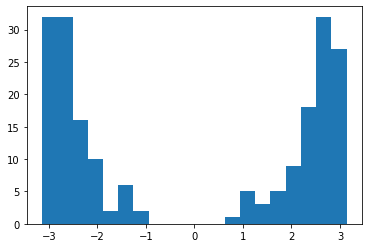

In [1258]:
plt.hist(a, 20)

In [1260]:
average_angle(a)

3.114996598568746

In [1263]:
std_angle(a)

-8.111704882900334

In [1147]:
ind_peaks = find_corr_peaks(c, tlags)

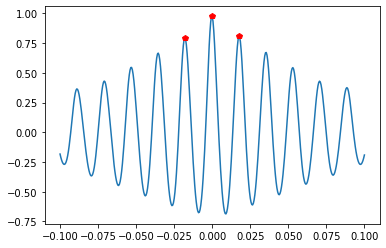

In [1148]:
plt.plot(tlags, c)
plt.plot(np.array(tlags)[ind_peaks], np.array(c)[ind_peaks], 'rp')

In [ ]:
plt.imshow

In [1110]:
dphs.shape

(15, 15, 30)

(array([24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([-0.03030303, -0.02727273, -0.02424242, -0.02121212, -0.01818182,
        -0.01515152, -0.01212121, -0.00909091, -0.00606061, -0.0030303 ,
         0.        ]),
 <BarContainer object of 10 artists>)

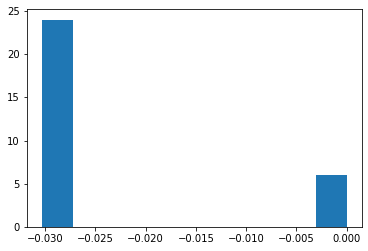

In [1113]:
plt.hist(dphs[5,5,:])

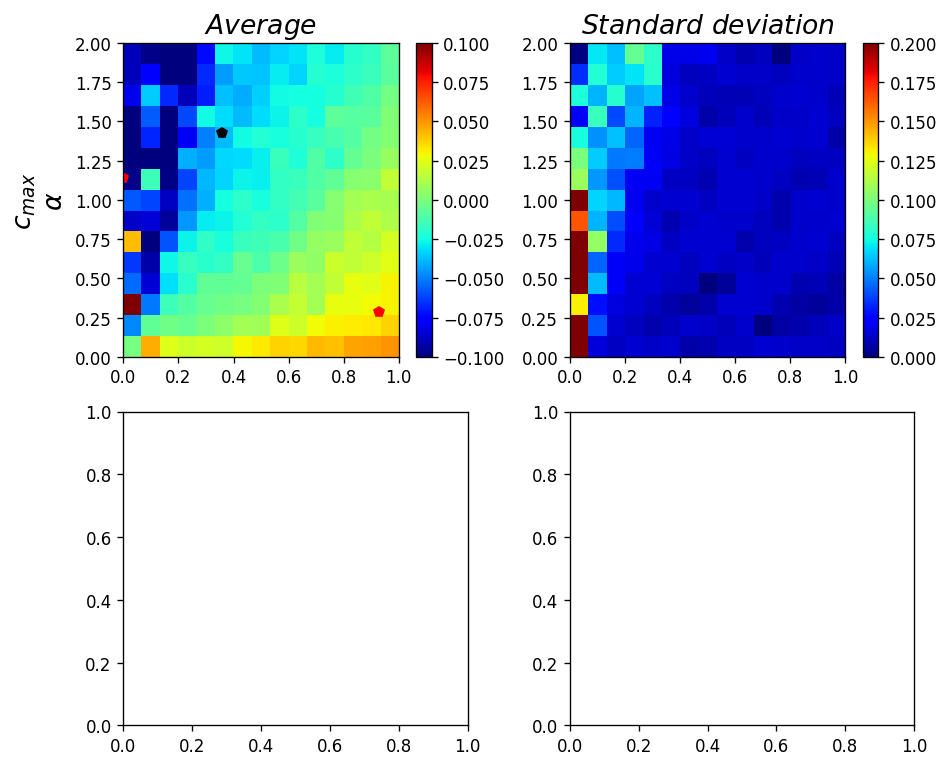

In [1109]:
x = obj.controls["beta_set"]  # -> inhibition
y = obj.controls["alpha_set"] # -> excitation

fig, axs = plt.subplots(2, 2, dpi=120, figsize=(8,6.5))
plt.axes(axs[0][0])
im = np.average(dphs, axis=2)
hhtools.imshow_xy(im, x=x, y=y, vmax=0.1, vmin=-0.1, cmap="jet")
plt.colorbar()
plt.ylabel(r"$c_{max}$"+"\n"+r"$\alpha$", fontsize=16)
plt.title(r"$Average$", fontsize=16)

plt.plot(x[5], y[10], 'kp')
plt.plot(x[0], y[8], 'rp')
plt.plot(x[13], y[2], 'rp')

plt.axes(axs[0][1])
im = np.std(dphs, axis=2)
hhtools.imshow_xy(im, x=x, y=y, vmax=0.2, vmin=-0.0, cmap="jet")
plt.colorbar()
plt.title(r"$Standard$ $deviation$", fontsize=16)

# plt.axes(axs[1][0])
# im = np.average(tlag_peaks, axis=2)
# hhtools.imshow_xy(im, x=x, y=y, vmax=0.04, vmin=-0.04, cmap="jet")
# plt.colorbar()
# plt.ylabel(r"$\tau_{lag}$"+"\n"+r"$\alpha$", fontsize=16)
# plt.xlabel(r"$\beta$", fontsize=16)

# plt.axes(axs[1][1])
# im = np.std(tlag_peaks, axis=2)
# hhtools.imshow_xy(im, x=x, y=y, vmax=0.01, vmin=-0.0, cmap="jet")
# plt.colorbar()
# plt.xlabel(r"$\beta$", fontsize=16)

plt.tight_layout()
plt.show()

# Symmetric case

In [481]:
obj = hhtools.SummaryLoader("./symmetric_case_low2//")
print(obj.summary["chi"].shape)
print(obj.controls.keys())

(15, 15, 5, 3, 3)
dict_keys(['alpha_set', 'beta_set', 'id_rank'])


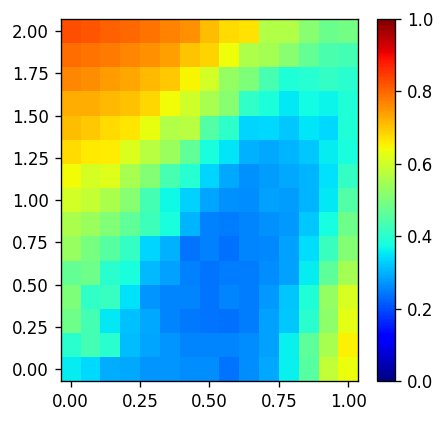

In [482]:
x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]
im = np.average(obj.summary["chi"][:,:,3,:,2], axis=2)

plt.figure(dpi=120, figsize=(4,4))
plt.pcolormesh(x, y, im, cmap="jet", vmax=1, vmin=0)
plt.colorbar()
plt.show()

In [1266]:
!cat symmetric_case_low2/id000000_info.txt

Size: 2000
ntypes: 4
type_range: 800, 1000, 1800, 2000, 
w:
0.004428, 0.004428, 0.000000, 0.000000, 
0.041624, 0.041624, 0.000000, 0.000000, 
0.000000, 0.000000, 0.005976, 0.005976, 
0.000000, 0.000000, 0.026893, 0.026893, 
taur, taud
0.500000, 1.000000
1.000000, 2.500000
0.500000, 1.000000
2.000000, 8.000000
mean indegree:
40.800000, 40.800000, 0.000000, 0.000000, 
30.600000, 30.600000, 0.000000, 0.000000, 
0.000000, 0.000000, 22.400000, 22.400000, 
0.000000, 0.000000, 14.000000, 14.000000, 
connection prob (out):
0.051000, 0.051000, 0.000000, 0.000000, 
0.153000, 0.153000, 0.000000, 0.000000, 
0.000000, 0.000000, 0.028000, 0.028000, 
0.000000, 0.000000, 0.070000, 0.070000, 
t_lag: 0.000000


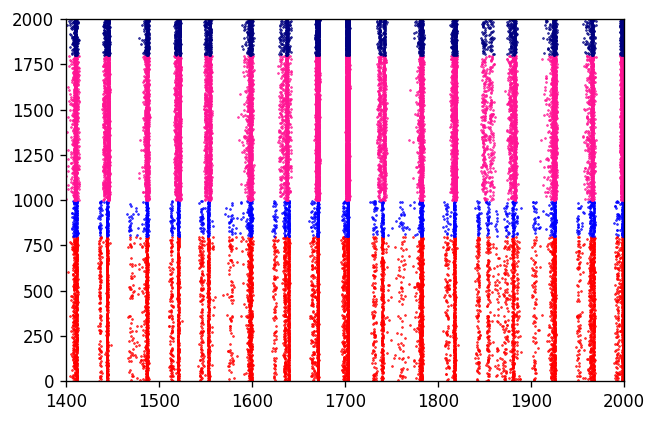

In [953]:
# data = obj.load_detail(0, 0, 2, 0)
data = obj.load_detail(13, 2, 2, 0)

plt.figure(dpi=120, figsize=(6, 4))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(1400, 2000))
plt.ylim([0, 2000])
plt.show()

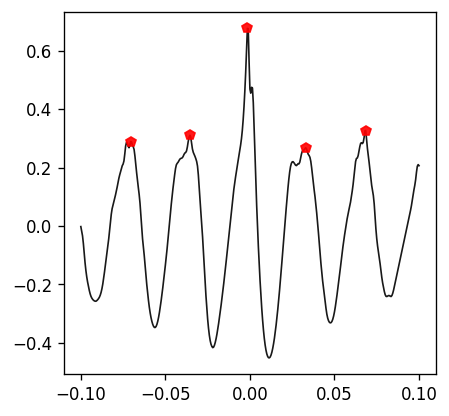

In [945]:
data = obj.load_detail(13, 1, 2, 0)

# c_auto, tlags  = cross_correlation(data['vlfp'][1], data['vlfp'][1], trange=[1.5, 2.5], tlag_max=0.1)
c_cross, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][2], trange=[1.5, 2.5], tlag_max=0.1)

plt.figure(dpi=120, figsize=(4,4))
plt.plot(tlags, c_cross, 'k', lw=1, alpha=0.9, zorder=-1)
ind_peaks, _ = find_peaks(c_cross, width=0.001, prominence=0.05)
plt.plot(tlags[ind_peaks], c_cross[ind_peaks], 'rp', lw=1, alpha=0.9, zorder=-1)
plt.show()

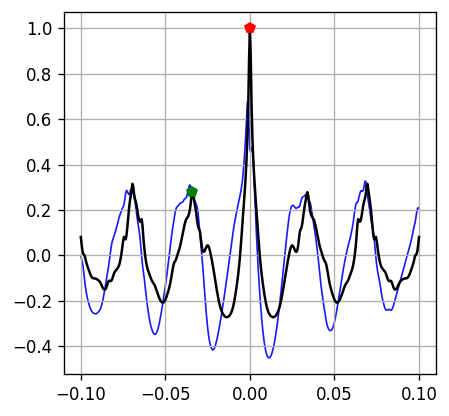

Phase difference: -0.02941176470588236


In [946]:
# data = obj.load_detail(1, 13, 2, 0)

# c_auto, tlags  = cross_correlation(data['vlfp'][1], data['vlfp'][1], trange=[1.5, 2.5], tlag_max=0.1)
# c_cross, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][2], trange=[1.5, 2.5], tlag_max=0.1)
c_auto, tlags  = cross_correlation(data['vlfp'][1], data['vlfp'][1], trange=[t0, t0+tw], tlag_max=0.1)
c_cross, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)

nid_peaks = find_corr_peaks(c_auto)

plt.figure(dpi=120, figsize=(4,4))
plt.plot(tlags, c_auto, 'k', lw=1.5)
plt.plot(tlags, c_cross, 'b', lw=1, alpha=0.9, zorder=-1)

plt.plot(tlags[nid_peaks[0]], c_auto[nid_peaks[0]], 'rp', lw=1)
plt.plot(tlags[nid_peaks[1]], c_auto[nid_peaks[1]], 'gp', lw=1)
plt.grid(True)
plt.show()

# dphs = calculate_dphs(data['vlfp'][1], data['vlfp'][2], trange=[1.5, 2.5], tlag_max=0.1)
dphs = calculate_dphs(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
print("Phase difference:", dphs)

## Find peaks in cross-correlogram 

In [948]:
rank_type = 2

tw = 1
tm = 0.1
tmax = 2.5

sz = np.shape(obj.summary["chi"])
tbins = np.arange(1, tmax-tw+tm/2, tm)
sz_t = len(tbins)

c_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
tlag_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
dphs = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan

for n1 in range(sz[0]): # y
    for n2 in range(sz[1]): # x
        for n3 in range(sz[3]): # iteration
            data = obj.load_detail(n1, n2, rank_type, n3)
            for i, t0 in enumerate(tbins):
                dphs[n1, n2, n3*sz_t+i] = calculate_dphs(data['vlfp'][1], data['vlfp'][2], trange=[t0, t0+tw], tlag_max=0.1)
                tlag_peaks[n1, n2, n3*sz_t+i] = tlags[nl]

                

In [952]:
tlag_peaks.shape

(15, 15, 18)

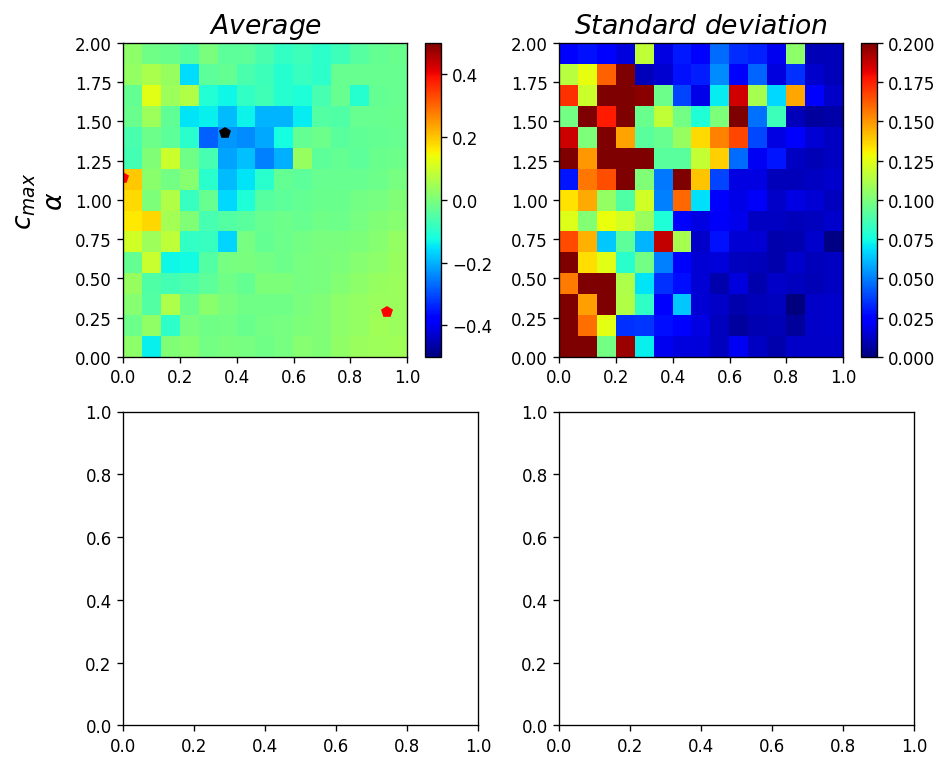

In [963]:
x = obj.controls["beta_set"]  # -> inhibition
y = obj.controls["alpha_set"] # -> excitation

fig, axs = plt.subplots(2, 2, dpi=120, figsize=(8,6.5))
plt.axes(axs[0][0])
im = np.average(dphs, axis=2)
hhtools.imshow_xy(im, x=x, y=y, vmax=0.5, vmin=-0.5, cmap="jet")
plt.colorbar()
plt.ylabel(r"$c_{max}$"+"\n"+r"$\alpha$", fontsize=16)
plt.title(r"$Average$", fontsize=16)

plt.plot(x[5], y[10], 'kp')
plt.plot(x[0], y[8], 'rp')
plt.plot(x[13], y[2], 'rp')

plt.axes(axs[0][1])
im = np.std(dphs, axis=2)
hhtools.imshow_xy(im, x=x, y=y, vmax=0.2, vmin=-0.0, cmap="jet")
plt.colorbar()
plt.title(r"$Standard$ $deviation$", fontsize=16)

# plt.axes(axs[1][0])
# im = np.average(tlag_peaks, axis=2)
# hhtools.imshow_xy(im, x=x, y=y, vmax=0.04, vmin=-0.04, cmap="jet")
# plt.colorbar()
# plt.ylabel(r"$\tau_{lag}$"+"\n"+r"$\alpha$", fontsize=16)
# plt.xlabel(r"$\beta$", fontsize=16)

# plt.axes(axs[1][1])
# im = np.std(tlag_peaks, axis=2)
# hhtools.imshow_xy(im, x=x, y=y, vmax=0.01, vmin=-0.0, cmap="jet")
# plt.colorbar()
# plt.xlabel(r"$\beta$", fontsize=16)

plt.tight_layout()
plt.show()

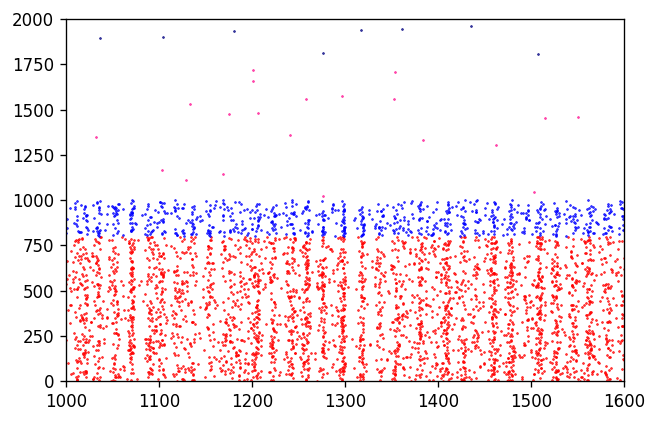

In [986]:
# data = obj.load_detail(0, 0, 2, 0)
# data = obj.load_detail(10, 5, 2, 1)
# data = obj.load_detail(8, 0, 2, 0)
data = obj.load_detail(2, 14, 3, 1)

plt.figure(dpi=120, figsize=(6, 4))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(1000, 1600))
plt.ylim([0, 2000])
plt.show()

In [987]:
tag = obj.get_id(2, 14, 3, 1)
print(tag)

670


In [989]:
obj.controls["alpha_set"][2], obj.controls["beta_set"][14]

(0.285714, 1.0)

In [988]:
!cat symmetric_case_low2/id003370_info.txt

Size: 2000
ntypes: 4
type_range: 800, 1000, 1800, 2000, 
w:
0.002649, 0.002649, 0.003746, 0.003746, 
0.024901, 0.024901, 0.024901, 0.024901, 
0.005484, 0.005484, 0.003878, 0.003878, 
0.017450, 0.017450, 0.017450, 0.017450, 
taur, taud
0.500000, 1.000000
1.000000, 2.500000
0.500000, 1.000000
2.000000, 8.000000
mean indegree:
114.000000, 114.000000, 228.000000, 228.000000, 
85.500000, 85.500000, 85.500000, 85.500000, 
106.400000, 106.400000, 53.200000, 53.200000, 
33.250000, 33.250000, 33.250000, 33.250000, 
connection prob (out):
0.142500, 0.142500, 0.285000, 0.285000, 
0.427500, 0.427500, 0.427500, 0.427500, 
0.133000, 0.133000, 0.066500, 0.066500, 
0.166250, 0.166250, 0.166250, 0.166250, 
t_lag: 0.000000
poisson type 0 (sd=0)
nu_pos_mu: 5338.540778
w_pos_mu: 0.002000
poisson type 1 (sd=0)
nu_pos_mu: 3984.332828
w_pos_mu: 0.002000


In [983]:
!cat symmetric_case_low2/id003370_result.txt

num_types:2
chi:0.421004,0.392040,0.469205,
cv:0.777789,0.790237,0.764272,
frs_m:4.902595,5.737197,4.067997,
frs_s:3.777622,4.059772,3.265855,
spike_syn:
0.000000,0.000000,0.000000,
0.000000,0.000000,0.000000,
0.000000,0.000000,0.000000,


In [696]:
rank_type = 2

tw = 1
tm = 0.1
tmax = 2.5

sz = np.shape(obj.summary["chi"])
tbins = np.arange(1, tmax-tw+tm/2, tm)
sz_t = len(tbins)

c_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan
tlag_peaks = np.zeros([sz[0], sz[1], sz[3]*sz_t]) * np.nan

for n1 in range(sz[0]): # y
    for n2 in range(sz[1]): # x
        for n3 in range(sz[3]): # iteration
            data = obj.load_detail(n1, n2, rank_type, n3)
            for i, t0 in enumerate(tbins):
                c, tlags = cross_correlation(data['vlfp'][1], data['vlfp'][1], trange=[t0, t0+tw], tlag_max=0.1)
                nid = np.argmax(c)
                
                # c_peaks[n1, n2, n3*sz_t+i] = c[nid]
                # tlag_peaks[n1, n2, n3*sz_t+i] = tlags[nid]
                
                nl, c2_l = find_local_max(c, nid, d=1)
                if np.isnan(nl):
                    continue
                c_peaks[n1, n2, n3*sz_t+i] = c2_l
                tlag_peaks[n1, n2, n3*sz_t+i] = tlags[nl]

                

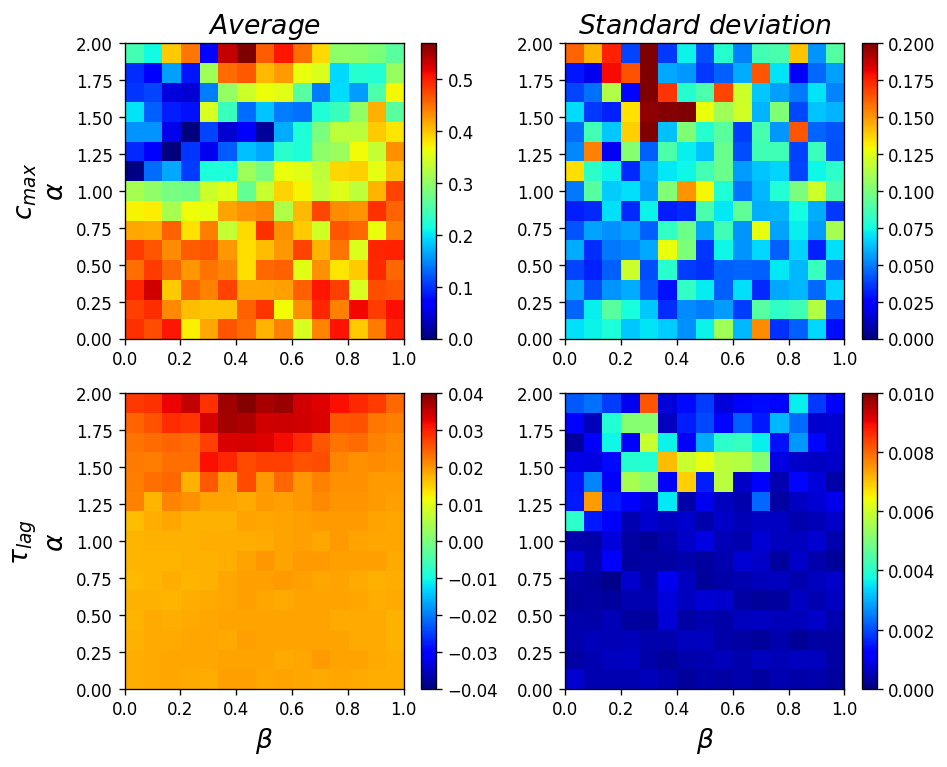

In [697]:
x = obj.controls["beta_set"]  # -> inhibition
y = obj.controls["alpha_set"] # -> excitation

fig, axs = plt.subplots(2, 2, dpi=120, figsize=(8,6.5))
plt.axes(axs[0][0])
im = np.average(c_peaks, axis=2)
hhtools.imshow_xy(im, x=x, y=y, vmax=None, vmin=0, cmap="jet")
plt.colorbar()
plt.ylabel(r"$c_{max}$"+"\n"+r"$\alpha$", fontsize=16)
plt.title(r"$Average$", fontsize=16)

plt.axes(axs[0][1])
im = np.std(c_peaks, axis=2)
hhtools.imshow_xy(im, x=x, y=y, vmax=0.2, vmin=-0.0, cmap="jet")
plt.colorbar()
plt.title(r"$Standard$ $deviation$", fontsize=16)

plt.axes(axs[1][0])
im = np.average(tlag_peaks, axis=2)
hhtools.imshow_xy(im, x=x, y=y, vmax=0.04, vmin=-0.04, cmap="jet")
plt.colorbar()
plt.ylabel(r"$\tau_{lag}$"+"\n"+r"$\alpha$", fontsize=16)
plt.xlabel(r"$\beta$", fontsize=16)

plt.axes(axs[1][1])
im = np.std(tlag_peaks, axis=2)
hhtools.imshow_xy(im, x=x, y=y, vmax=0.01, vmin=-0.0, cmap="jet")
plt.colorbar()
plt.xlabel(r"$\beta$", fontsize=16)

plt.tight_layout()
plt.show()

In [586]:
c_peaks.shape

(15, 15, 3, 4)

In [ ]:
x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]
im = np.average(obj.summary["chi"][:,:,3,:,2], axis=2)

plt.figure(dpi=120, figsize=(4,4))
plt.pcolormesh(x, y, im, cmap="jet", vmax=1, vmin=0)
plt.colorbar()
plt.show()

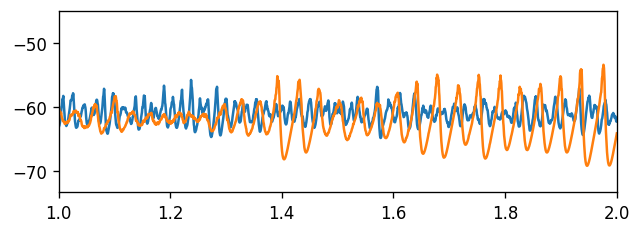

In [539]:
plt.figure(dpi=120, figsize=(6, 2))
plt.plot(data['ts'], data['vlfp'][1])
plt.plot(data['ts'], data['vlfp'][2])
plt.xlim([1, 2])
plt.show()

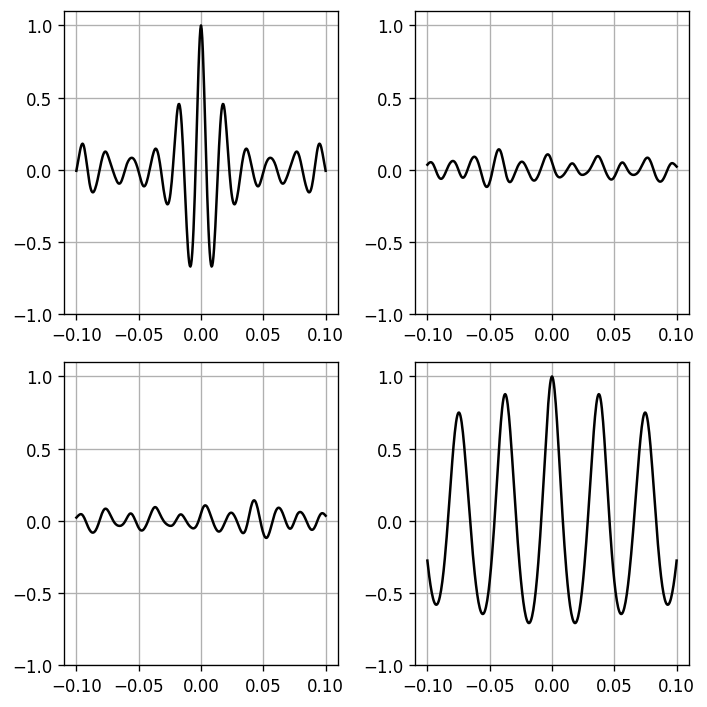

In [475]:
vlfp = np.array(data["vlfp"][1:])
idt = data["ts"] >= 1
vlfp = vlfp[:,idt]

draw_cross_correlogram(vlfp, 0.05)

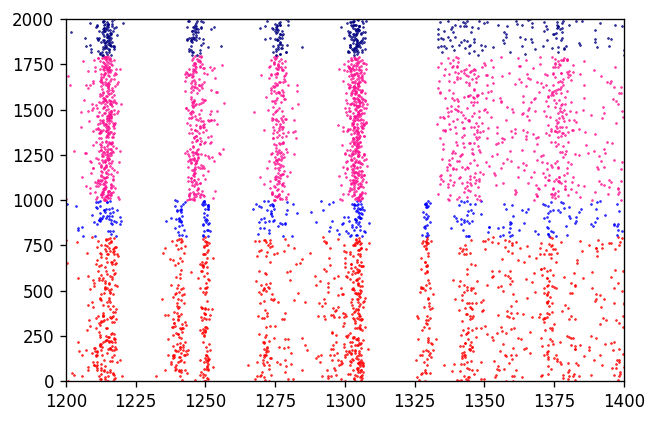

In [476]:
data = obj.load_detail(12, 6, 2, 0)

plt.figure(dpi=120, figsize=(6, 4))
# hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(1000, 2000))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(1200, 1400))
plt.ylim([0, 2000])
plt.show()

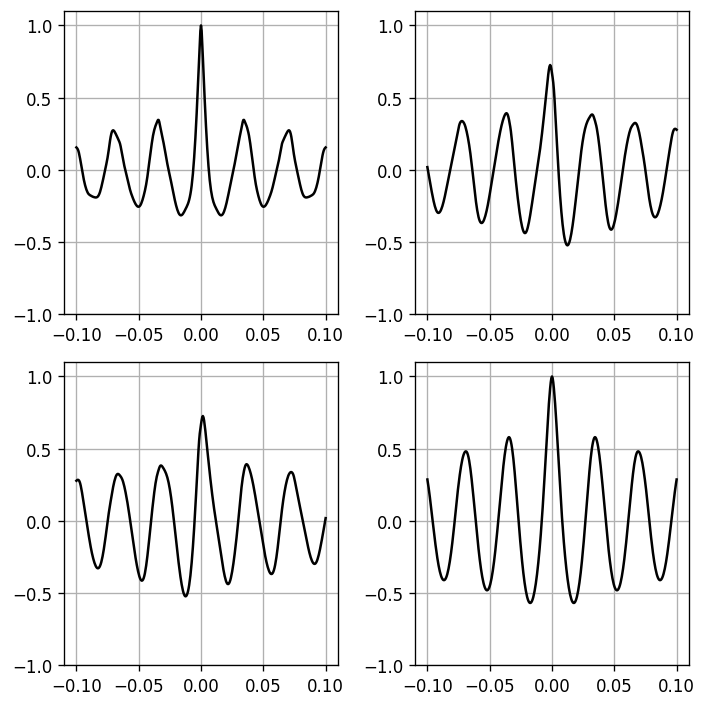

In [477]:
vlfp = np.array(data["vlfp"][1:])
idt = data["ts"] >= 1
vlfp = vlfp[:,idt]

draw_cross_correlogram(vlfp, 0.02)

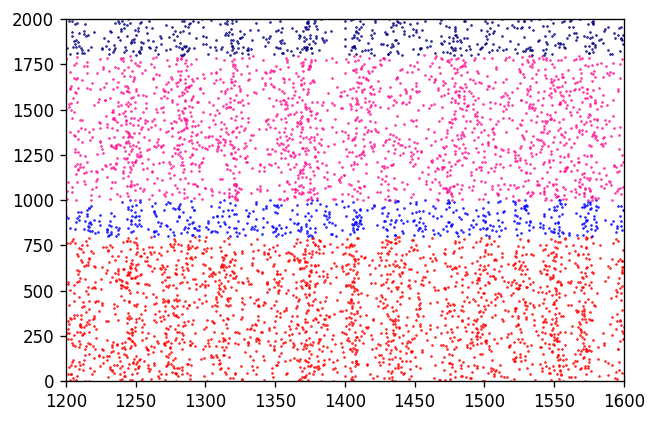

In [467]:
data = obj.load_detail(5, 5, 0, 0)

plt.figure(dpi=120, figsize=(6, 4))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(1200, 1600))
plt.ylim([0, 2000])
plt.show()

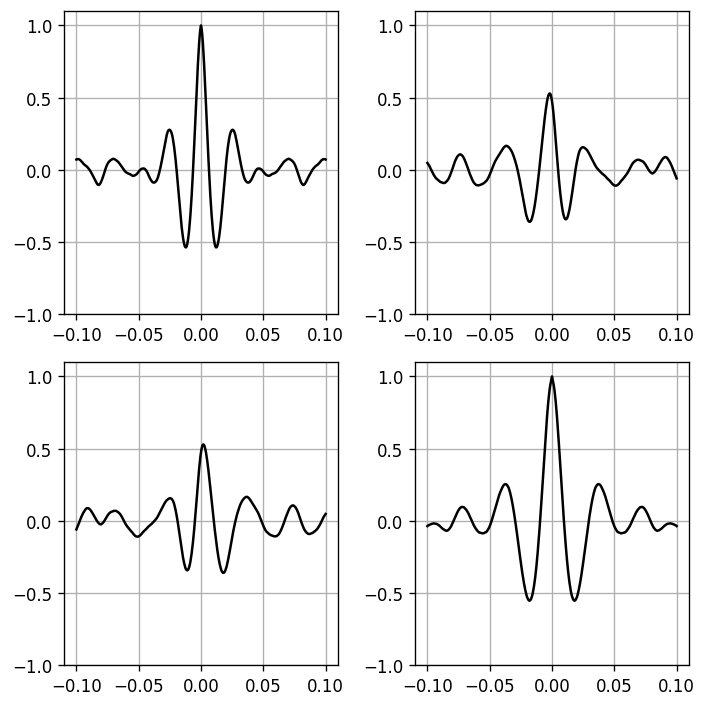

In [468]:
vlfp = np.array(data["vlfp"][1:])
idt = data["ts"] >= 1
vlfp = vlfp[:,idt]

draw_cross_correlogram(vlfp, 0.02)

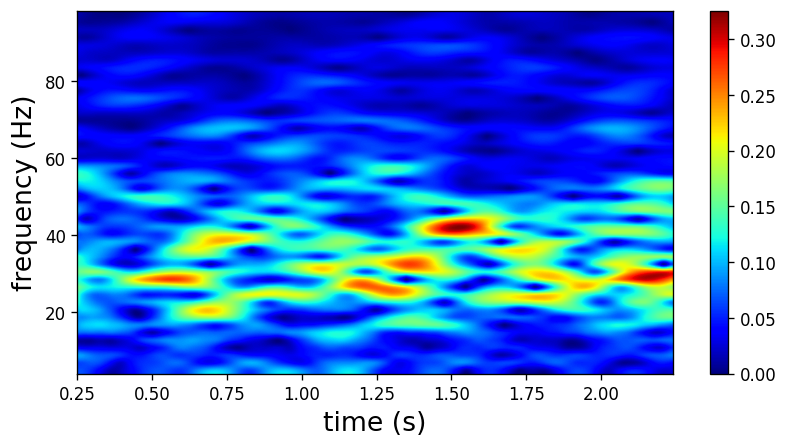

In [469]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(8, 4))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

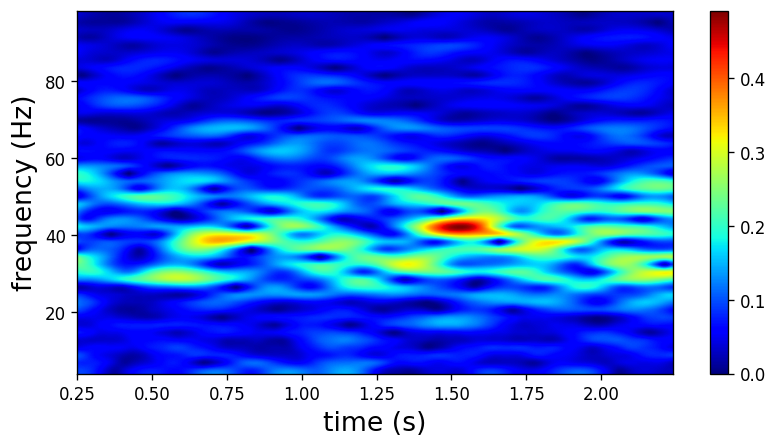

In [470]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][1], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(8, 4))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

In [471]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][3], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(8, 4))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

IndexError: list index out of range

In [199]:
ind_spike = np.random.permutation(np.arange(2000))

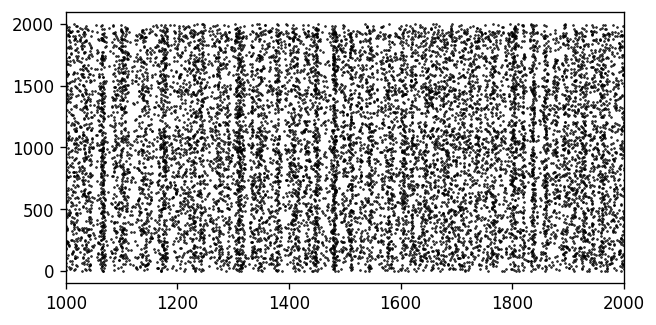

In [200]:
step_spk = data["step_spk"]
dt = 0.01

cid = 0
N = len(step_spk)
# for n in range(N):

plt.figure(dpi=120, figsize=(6, 3))
for i, n in enumerate(ind_spike):
    t_spk = np.array(step_spk[n]) * dt
    plt.plot(t_spk, np.ones_like(t_spk)*i, '.', ms=1, c='k')
plt.xlim([1000, 2000])
plt.show()

In [244]:
1/2000

0.0005

In [294]:
def cross_correlation(x, y, dt=0.0005, tlag_max=None):
    """
    Cross-correlation between x and y
    - y will be moved to x
    - x and y must have same length
    
    Let t_peak is the peak time, 
    if t_peak < 0: y leads x
    if t_peak > 0: x leads y
    """
    xs = np.array(x) - np.average(x)
    ys = np.array(y) - np.average(y)
    
    if tlag_max is None:
        c = np.correlate(xs, ys, mode="full")
        num = np.concatenate([np.arange(1, len(ys)), np.arange(len(ys), 0, -1)])
        c = c / num
        num_lag = len(ys)-1
        
    else:
        num_lag = int(tlag_max/dt)
        arr_app = np.zeros(num_lag)
        xs_tmp = np.concatenate((arr_app, xs, arr_app))
        
        c = np.correlate(xs_tmp, ys, mode="valid")
        n0 = len(ys) - num_lag
        num = np.concatenate((np.arange(n0, len(ys)), np.arange(len(ys), n0-1, -1)))
        c = c / num
    
    c /= np.std(xs) * np.std(ys)
    tlags = np.arange(-num_lag, num_lag+1) * dt
    
    return c, tlags

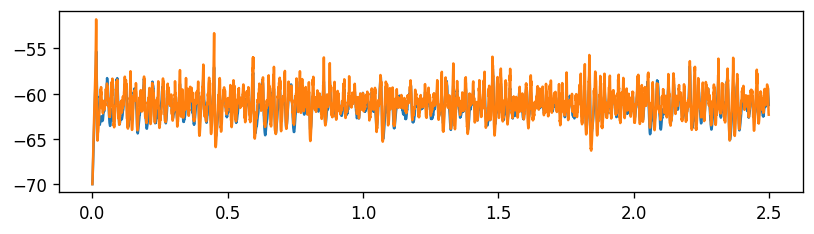

In [327]:
plt.figure(dpi=120, figsize=(8, 2))
plt.plot(data["ts"], data["vlfp"][0])
plt.plot(data["ts"], data["vlfp"][2])


In [339]:
c, tlags = cross_correlation(data["vlfp"][1], data["vlfp"][1], tlag_max=0.1)
# c, tlags = cross_correlation(data["vlfp"][0], data["vlfp"][0], tlag_max=None)

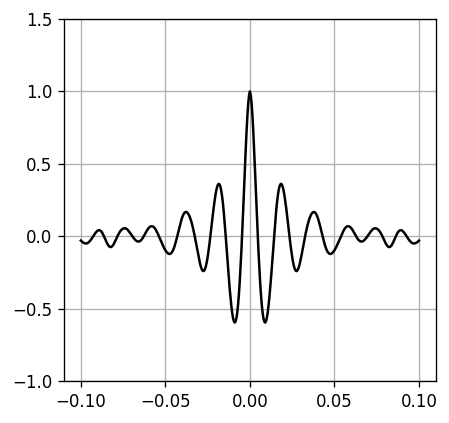

In [ ]:
plt.figure(dpi=120, figsize=(4,4))
plt.plot(tlags, c, 'k')
# plt.xlim([-0.5, 0.5])
plt.ylim([-1, 1.5])
plt.grid(True)
plt.show()

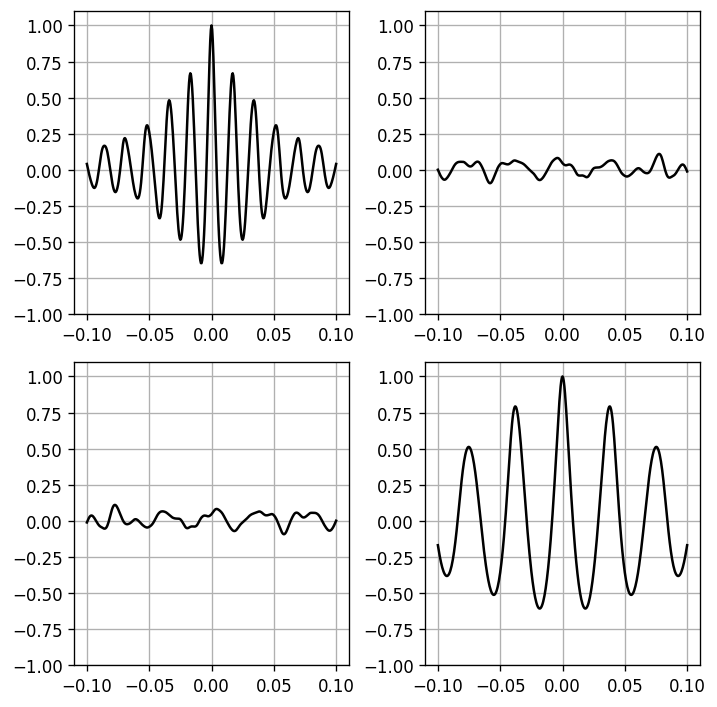

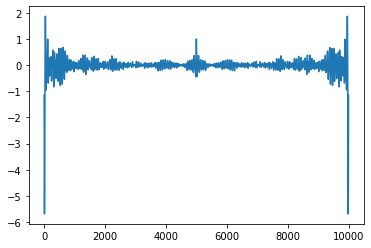

In [235]:
plt.plot(c)

In [ ]:
xcorr = np.correlate(y, x_cp, mode="valid")

In [214]:
len(xcorr)

5999

In [215]:
len(z)

3000

In [239]:
z = data["vlfp"][0][data["ts"] >= 1]
z = z - np.average(z)
v = np.var(z)


In [240]:
np.concatenate([[1,2,3], [1,3,4]])

array([1, 2, 3, 1, 3, 4])

In [241]:
xcorr = np.correlate(z, z, mode="full")
norm = np.concatenate([np.arange(1, len(z)), np.arange(len(z), 0, -1)])

xcorr_norm = xcorr / norm / v

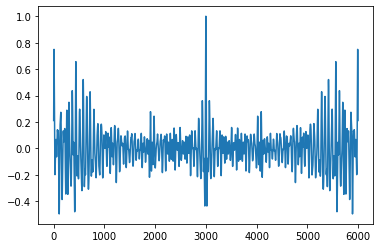

In [242]:
plt.plot(xcorr_norm)

In [226]:
xcorr_norm[2999]

1.0000000274516565

In [202]:
len(data["vlfp"])

5

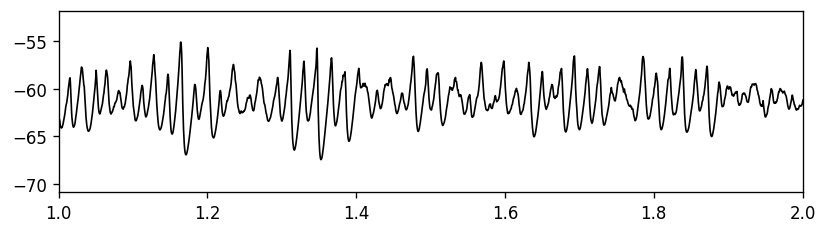

In [170]:
plt.figure(dpi=120, figsize=(8, 2))
plt.plot(data["ts"], data["vlfp"][4], c='k', lw=1)
plt.xlim([1, 2])
plt.show()

In [166]:
yf, f = hhtools.get_fft(data["vlfp"][0][data["ts"]>1], 2000)

In [168]:
1 > None

TypeError: '>' not supported between instances of 'int' and 'NoneType'

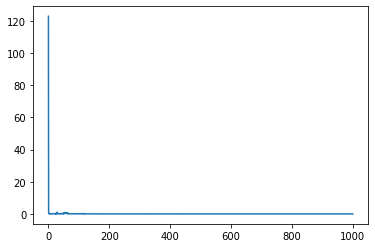

In [167]:
plt.plot(f, yf)

In [140]:
tag = obj.get_id(0, 9, 0, 0)
print(tag)

54


In [44]:
vlfps, fs = hhtools.load_vlfp("./symmetric_case/id000054_lfp.dat")

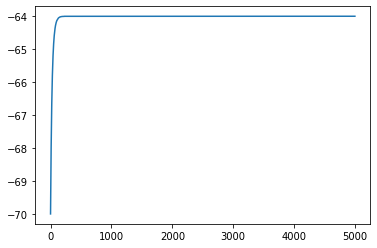

In [48]:
plt.plot(vlfps[2])

In [80]:
with open("./symmetric_case_low/id000000_spk.dat", "r") as fid:
    # data = np.fromfile(fid, dtype=np.intc)
    line = fid.readline()
    

In [82]:
len(line.split(","))

2001

In [75]:
print(data[0], data[1], len(data))

2000 250000 1024


In [76]:
data[-1]

0

In [ ]:
with open("./sy

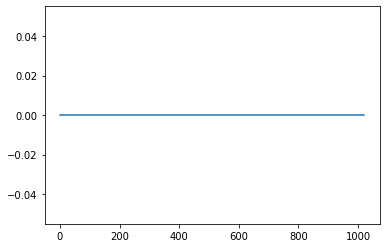

In [58]:
plt.plot(data[2:])

In [29]:
len(data)

1024

In [32]:
data[4]

0